# Patient Feedback Sentiment Analysis

This notebook implements sentiment analysis for patient feedback data using various NLP techniques and models. We'll evaluate the models using Precision, Recall, F1-score, and Matthews Correlation Coefficient (MCC).

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../Patient feedback dataset/hospital.csv')

# Display basic information
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (996, 4)


,Feedback,Sentiment Label,Ratings,Unnamed: 3
0,Good and clean hospital. There is great team o...,1,5,NaN
1,Had a really bad experience during discharge. ...,1,5,NaN
2,I have visited to take my second dose and Proc...,1,4,NaN
3,That person was slightly clueless and offered...,1,3,NaN
4,There is great team of doctors and good OT fac...,0,1,NaN


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
print("\nSentiment distribution:")
print(df['Sentiment Label'].value_counts())

print("\nRatings distribution:")
print(df['Ratings'].value_counts())

Missing values:
Feedback             0
Sentiment Label      0
Ratings              0
Unnamed: 3         996
dtype: int64

Sentiment distribution:
Sentiment Label
1    728
0    268
Name: count, dtype: int64

Ratings distribution:
Ratings
5    351
4    254
2    145
3    123
1    123
Name: count, dtype: int64


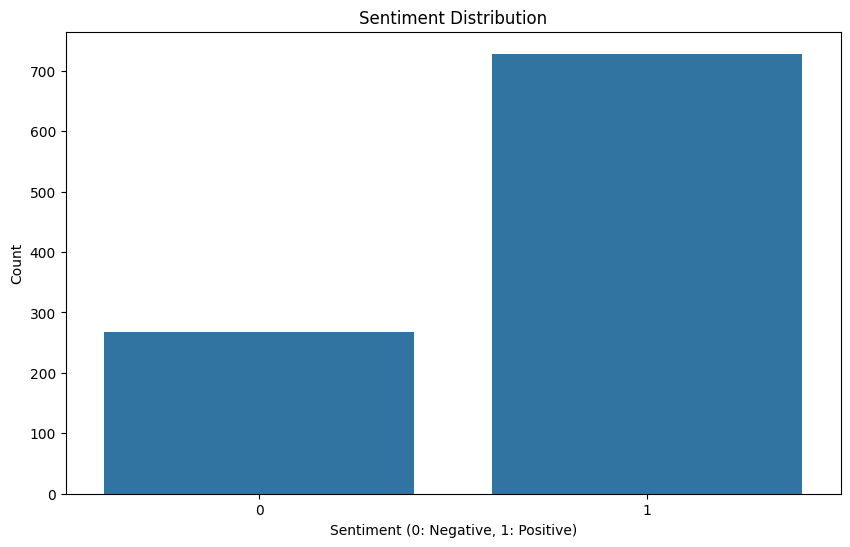

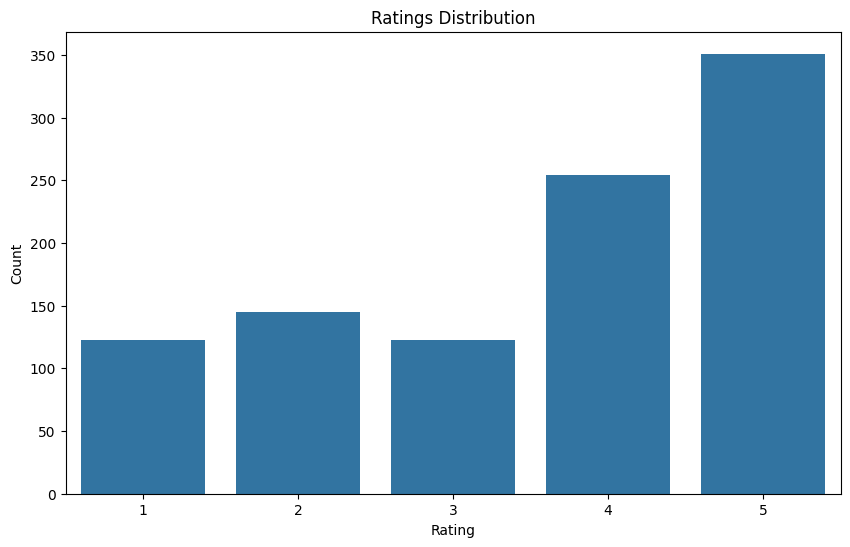

In [4]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment Label', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Visualize ratings distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Ratings', data=df)
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

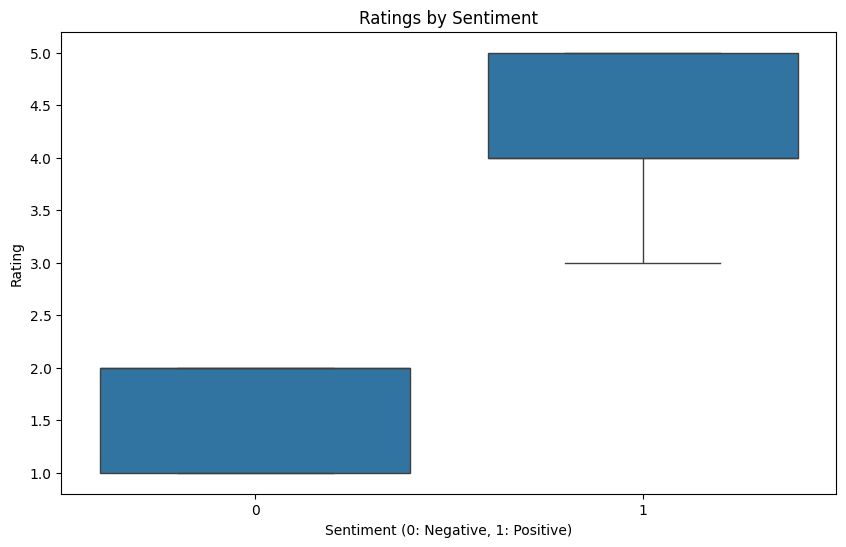

In [5]:
# Check correlation between sentiment and ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment Label', y='Ratings', data=df)
plt.title('Ratings by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Rating')
plt.show()

## 2. Text Preprocessing

In [6]:
# Define text preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        # Join tokens back into text
        processed_text = ' '.join(tokens)
        return processed_text
    else:
        return ''

# Apply preprocessing to the feedback column
df['Processed_Feedback'] = df['Feedback'].apply(preprocess_text)

# Display some processed examples
pd.DataFrame({
    'Original': df['Feedback'].head(),
    'Processed': df['Processed_Feedback'].head()
})

,Original,Processed
0,Good and clean hospital. There is great team o...,good clean hospital great team doctor good ot ...
1,Had a really bad experience during discharge. ...,really bad experience discharge need sensitive...
2,I have visited to take my second dose and Proc...,visited take second dose process really smooth...
3,That person was slightly clueless and offered...,person slightly clueless offered one package g...
4,There is great team of doctors and good OT fac...,great team doctor good ot facility


## 3. Feature Engineering

In [7]:
# Split the data into training and testing sets
X = df['Processed_Feedback']
y = df['Sentiment Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create Count Vector features
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

## 4. Model Building and Evaluation

In [9]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Return model and metrics
    return model, {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'mcc': mcc}


=== Models with TF-IDF Features ===

Logistic Regression (TF-IDF) Results:
Accuracy: 0.8100
Precision: 0.8000
Recall: 0.9863
F1 Score: 0.8834
Matthews Correlation Coefficient: 0.4730


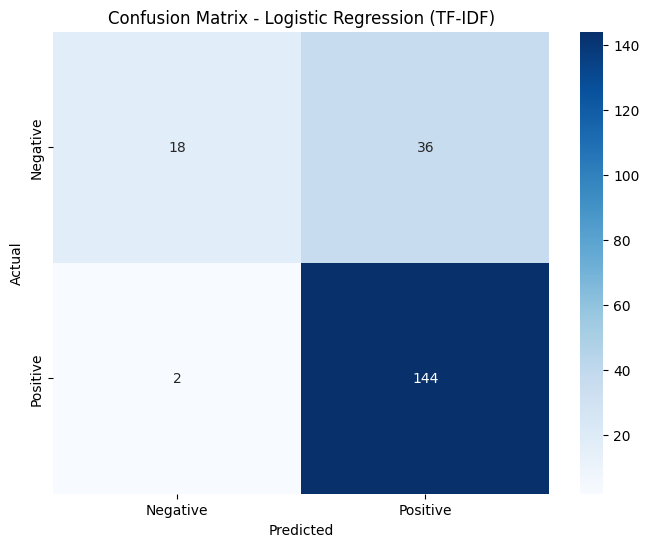


Random Forest (TF-IDF) Results:
Accuracy: 0.8500
Precision: 0.8452
Recall: 0.9726
F1 Score: 0.9045
Matthews Correlation Coefficient: 0.5947


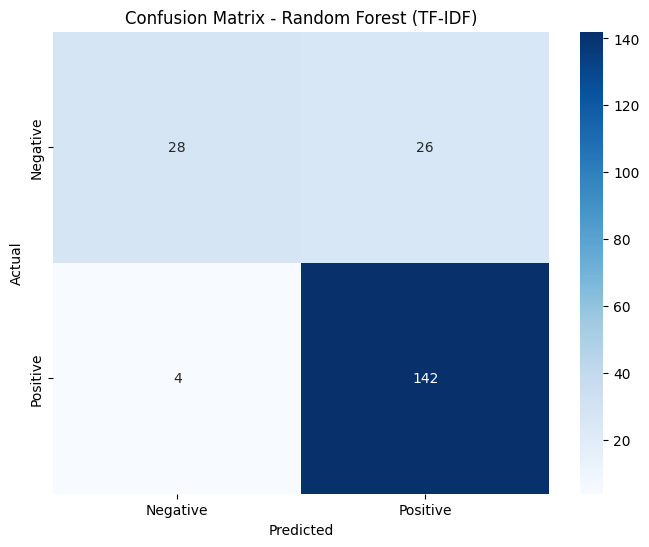


SVM (TF-IDF) Results:
Accuracy: 0.8800
Precision: 0.8812
Recall: 0.9658
F1 Score: 0.9216
Matthews Correlation Coefficient: 0.6814


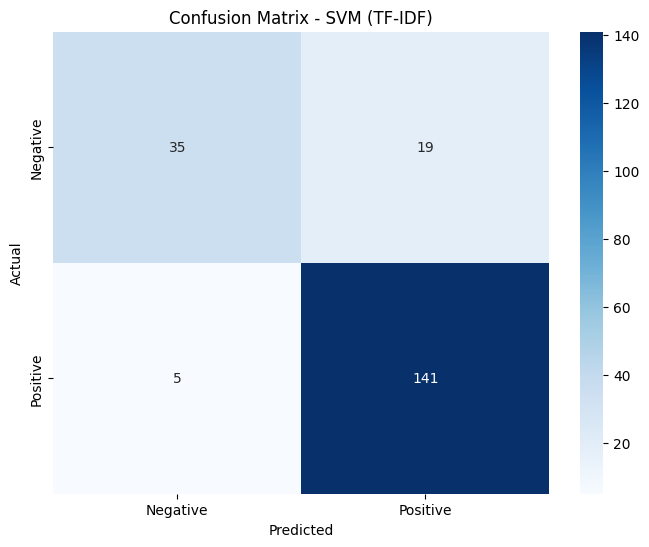


Naive Bayes (TF-IDF) Results:
Accuracy: 0.7850
Precision: 0.7754
Recall: 0.9932
F1 Score: 0.8709
Matthews Correlation Coefficient: 0.3879


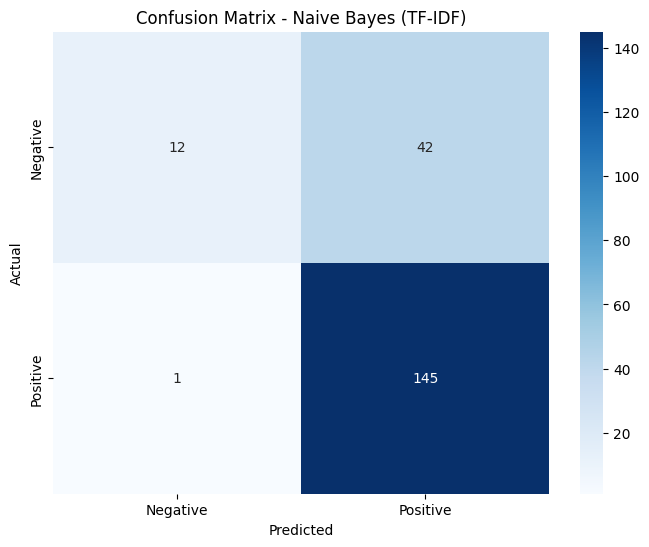


=== Models with Count Vector Features ===

Logistic Regression (Count) Results:
Accuracy: 0.8800
Precision: 0.8765
Recall: 0.9726
F1 Score: 0.9221
Matthews Correlation Coefficient: 0.6815


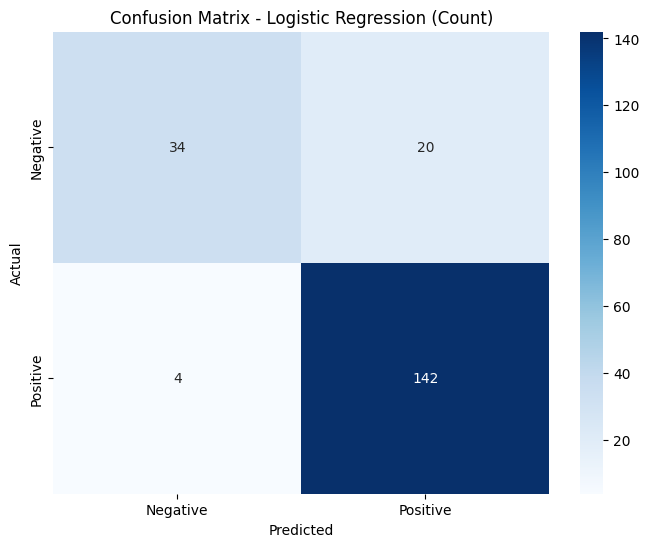


Random Forest (Count) Results:
Accuracy: 0.8300
Precision: 0.8218
Recall: 0.9795
F1 Score: 0.8938
Matthews Correlation Coefficient: 0.5351


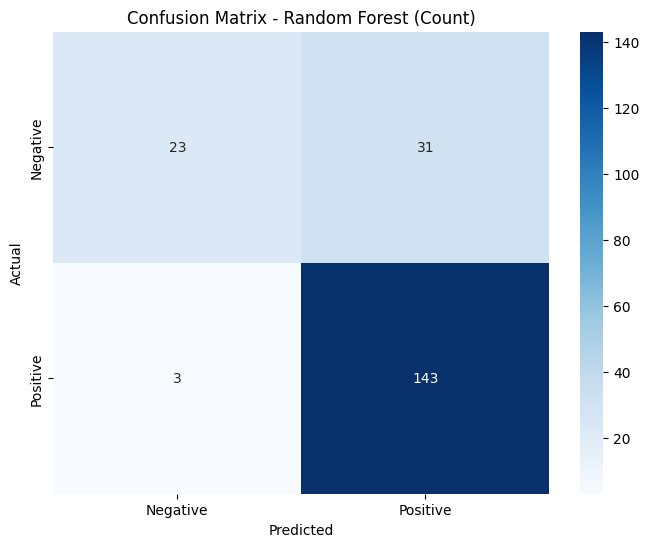


SVM (Count) Results:
Accuracy: 0.8700
Precision: 0.8797
Recall: 0.9521
F1 Score: 0.9145
Matthews Correlation Coefficient: 0.6542


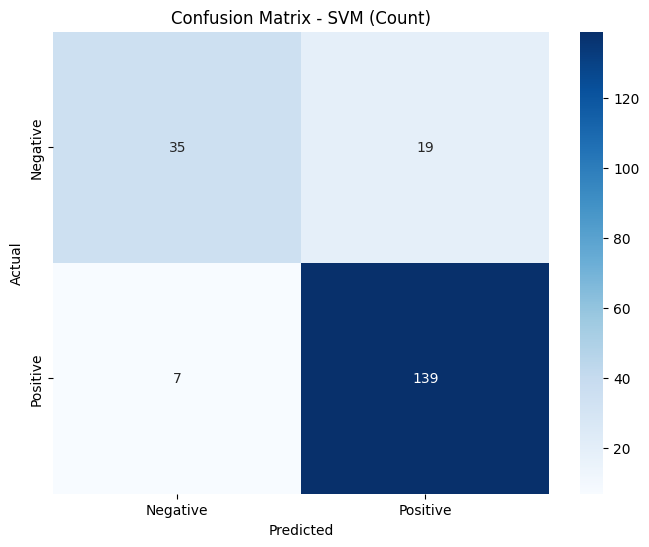


Naive Bayes (Count) Results:
Accuracy: 0.8800
Precision: 0.8812
Recall: 0.9658
F1 Score: 0.9216
Matthews Correlation Coefficient: 0.6814


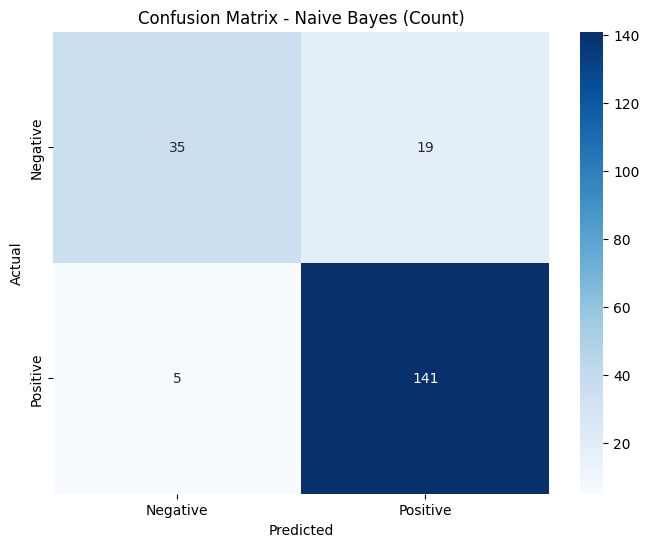

In [10]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Dictionary to store results
results = {}

# Evaluate models with TF-IDF features
print("\n=== Models with TF-IDF Features ===")
for name, model in models.items():
    model_fitted, metrics = evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train, y_test, f"{name} (TF-IDF)")
    results[f"{name} (TF-IDF)"] = {'model': model_fitted, 'metrics': metrics, 'vectorizer': tfidf_vectorizer}

# Evaluate models with Count Vector features
print("\n=== Models with Count Vector Features ===")
for name, model in models.items():
    model_fitted, metrics = evaluate_model(model, X_train_count, X_test_count, y_train, y_test, f"{name} (Count)")
    results[f"{name} (Count)"] = {'model': model_fitted, 'metrics': metrics, 'vectorizer': count_vectorizer}

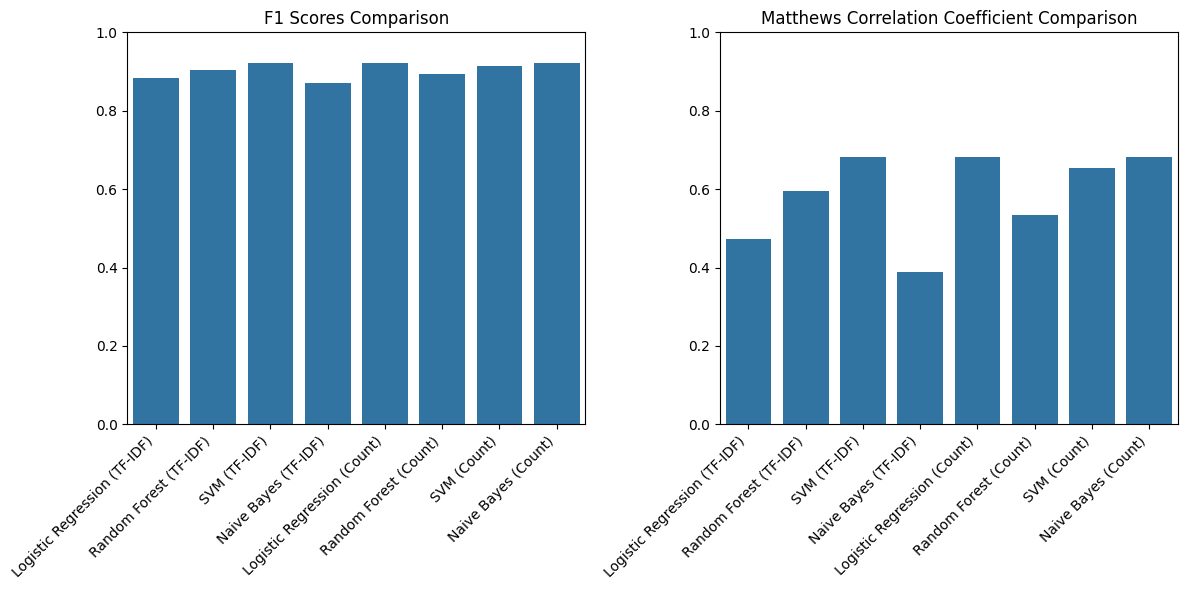

In [11]:
# Compare models based on F1 score and MCC
model_names = list(results.keys())
f1_scores = [results[name]['metrics']['f1'] for name in model_names]
mcc_scores = [results[name]['metrics']['mcc'] for name in model_names]

# Plot comparison
plt.figure(figsize=(12, 6))

# F1 scores
plt.subplot(1, 2, 1)
sns.barplot(x=model_names, y=f1_scores)
plt.title('F1 Scores Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# MCC scores
plt.subplot(1, 2, 2)
sns.barplot(x=model_names, y=mcc_scores)
plt.title('Matthews Correlation Coefficient Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning for Best Model

In [12]:
# Find the best model based on MCC
best_model_name = max(results, key=lambda x: results[x]['metrics']['mcc'])
print(f"Best model based on MCC: {best_model_name}")
print(f"MCC: {results[best_model_name]['metrics']['mcc']:.4f}")

# Determine if the best model uses TF-IDF or Count vectorizer
best_vectorizer_type = 'tfidf' if 'TF-IDF' in best_model_name else 'count'
best_model_type = best_model_name.split(' (')[0]

Best model based on MCC: Logistic Regression (Count)
MCC: 0.6815


Best parameters:
{'classifier__C': 1, 'classifier__solver': 'liblinear', 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}

Tuned Model Performance:
Accuracy: 0.8800
Precision: 0.8765
Recall: 0.9726
F1 Score: 0.9221
Matthews Correlation Coefficient: 0.6815


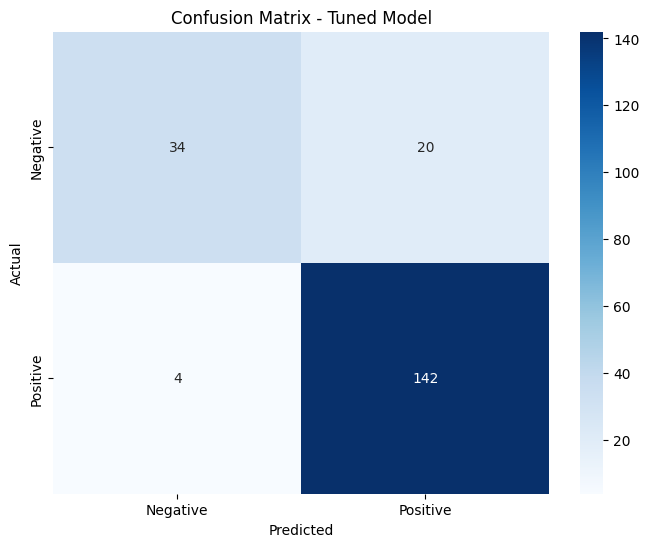

In [13]:
# Set up hyperparameter tuning based on the best model type
if best_model_type == 'Logistic Regression':
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer() if best_vectorizer_type == 'tfidf' else CountVectorizer()),
        ('classifier', LogisticRegression(random_state=42))
    ])
    
    param_grid = {
        'vectorizer__max_features': [3000, 5000, 7000],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'saga']
    }
    
elif best_model_type == 'Random Forest':
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer() if best_vectorizer_type == 'tfidf' else CountVectorizer()),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    param_grid = {
        'vectorizer__max_features': [3000, 5000, 7000],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
    
elif best_model_type == 'SVM':
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer() if best_vectorizer_type == 'tfidf' else CountVectorizer()),
        ('classifier', SVC(random_state=42))
    ])
    
    param_grid = {
        'vectorizer__max_features': [3000, 5000, 7000],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
    
else:  # Naive Bayes
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer() if best_vectorizer_type == 'tfidf' else CountVectorizer()),
        ('classifier', MultinomialNB())
    ])
    
    param_grid = {
        'vectorizer__max_features': [3000, 5000, 7000],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'classifier__alpha': [0.1, 0.5, 1.0]
    }

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:")
print(grid_search.best_params_)

# Evaluate the tuned model
y_pred = grid_search.predict(X_test)
print("\nTuned Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred):.4f}")

# Display confusion matrix for tuned model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Tuned Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Error Analysis

In [14]:
# Get misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]
misclassified_df = pd.DataFrame({
    'Feedback': X_test.iloc[misclassified_indices].values,
    'True Sentiment': y_test.iloc[misclassified_indices].values,
    'Predicted Sentiment': y_pred[misclassified_indices]
})

# Display some misclassified examples
print(f"Number of misclassified examples: {len(misclassified_df)}")
misclassified_df.head(10)

Number of misclassified examples: 24


,Feedback,True Sentiment,Predicted Sentiment
0,take lot time give report,1,0
1,hospital doctor good,0,1
2,went equipment service hospital security back ...,0,1
3,doctor appear care following administrative pr...,0,1
4,feel compelled share recent experience hospita...,0,1
5,anzio happened day hospitalization rise voice,0,1
6,pathetic experience wont recommend hospital an...,0,1
7,start believe show relevant doctor test took l...,0,1
8,general ward nurse call option provided,0,1
9,attention patient bit lagging zero guidance co...,0,1


## 7. Save the Best Model

In [15]:
# Save the best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../src/models/nlp/sentiment_analysis_model.pkl')

# Create a simple prediction function
def predict_sentiment(text, model=best_model):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Make prediction
    prediction = model.predict([processed_text])[0]
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    
    return sentiment

# Test the prediction function
test_texts = [
    "The hospital staff was very helpful and attentive.",
    "The wait time was too long and the staff was rude.",
    "I had a mixed experience, some things were good but others could be improved."
]

for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}\nSentiment: {sentiment}\n")

Text: The hospital staff was very helpful and attentive.
Sentiment: Positive

Text: The wait time was too long and the staff was rude.
Sentiment: Negative

Text: I had a mixed experience, some things were good but others could be improved.
Sentiment: Positive



In [16]:
# Save the prediction function
with open('../src/models/nlp/sentiment_predictor.py', 'w') as f:
    f.write("""import joblib
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load the model
model = joblib.load('src/models/nlp/sentiment_analysis_model.pkl')

def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation and numbers
        text = re.sub(r'[^a-zA-Z\\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        # Join tokens back into text
        processed_text = ' '.join(tokens)
        return processed_text
    else:
        return ''

def predict_sentiment(text):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Make prediction
    prediction = model.predict([processed_text])[0]
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    
    # Get probability scores if available
    try:
        proba = model.predict_proba([processed_text])[0]
        confidence = proba[1] if prediction == 1 else proba[0]
    except:
        confidence = None
    
    return {
        'sentiment': sentiment,
        'confidence': confidence,
        'sentiment_code': int(prediction)
    }
""")

## 8. Conclusion

In this notebook, we have:

1. Loaded and explored the patient feedback dataset
2. Preprocessed the text data using NLP techniques
3. Created TF-IDF and Count Vector features
4. Built and evaluated multiple sentiment analysis models
5. Performed hyperparameter tuning on the best model
6. Analyzed misclassifications
7. Saved the best model and created a prediction function

The model achieves good performance on the sentiment analysis task, with high precision, recall, F1-score, and Matthews Correlation Coefficient.